# 试验机器学习模型预测
part1全监督回归(1)线性模型：Ridge/Lasso/Elastic/BayesianRidge（2）KNN（3）树模型：DecisionTree/RandmoForest（4）集成模型：Adaboost/GradientBoostingDecisionTree/Xgboost/LightBGM（5）Stacking
part2半监督回归Coreg/Corareg

In [1]:
#导入库
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgbm
# File Loading Tools 
import os
PATH = "/Users/lihan/Documents/2016 PHM DATA CHALLENGE CMP DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-data"

# 0.处理数据

## 0.0 载入训练数据

In [2]:
train_path = os.path.join(PATH, "training")
dataframe_x = pd.DataFrame()
for file_name in os.listdir(train_path):
    # print(os.path.join(train_path, file_name))
    dataframe = pd.read_csv(os.path.join(train_path, file_name))
    dataframe_x = dataframe_x.append(dataframe,ignore_index=True)
dataframe_x.shape

(672744, 25)

In [3]:
y_path = "/Users/lihan/Documents/2016 PHM DATA CHALLENGE CMP DATA SET/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-training-removalrate.csv"
dataframe_y = pd.read_csv(y_path)
dataframe_y.shape

(1981, 3)

In [4]:
removed_y = dataframe_y.loc[(dataframe_y['AVG_REMOVAL_RATE'] >= 50) & (dataframe_y['AVG_REMOVAL_RATE'] <= 165)]
removed_y.shape

(1977, 3)

In [5]:
#(注意）y值的key是由WAFER_ID和STAGE两个字段共同组成的，merge中虽然没有指定left_index/left_on/right_index/right_on
#自动匹配了共同的字段WAFER_ID和STAGE
Train_data = pd.merge(dataframe_x, removed_y) 
Train_data.shape

(671422, 26)

## 0.1 将训练样例按['WAFER_ID','STAGE']分组

In [6]:
dataframe_group = Train_data.groupby(['WAFER_ID','STAGE'], sort = False)

In [7]:
dataframe_statistics = dataframe_group.agg(np.mean)
Train_data = dataframe_statistics.drop(columns=['TIMESTAMP'])
Train_data

,,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,RIPPLE_AIR_BAG_PRESSURE,...,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
WAFER_ID,STAGE,,,,,,,,,,,,,,,,,,,,,
2941014050,B,4.669591,1246.164717,282.763699,195.360624,3522.000000,65.032025,197.087719,50.446820,1655.743860,7.747741,...,373.849415,5.559617,0.906433,329.163743,14.711682,57.888196,160.196491,0.166667,35.882509,87.06210
3021014500,B,4.673469,1252.050534,283.034230,200.710506,3522.119534,50.179092,155.072886,38.171465,1188.328863,5.995759,...,375.615160,6.254859,0.784522,275.232653,17.855448,58.383842,160.326531,0.583090,25.803516,87.69855
2913014238,B,4.677326,1293.049903,285.185185,237.004737,3523.619186,63.540975,192.927907,49.390443,1619.690407,7.601876,...,387.914971,4.817910,0.906448,320.380233,14.494997,58.294446,160.502326,0.561047,35.165610,92.02575
2939014266,B,4.674419,1299.280523,285.363910,242.534453,3523.865552,64.490587,194.989535,49.940044,1643.555233,7.750661,...,389.784157,5.443718,0.906448,326.484884,14.479448,58.695685,160.269767,0.593023,35.512685,86.59425
2939014300,B,4.661765,1305.453431,285.726580,248.017429,3524.000000,64.277311,194.982353,49.878676,1660.597059,7.715775,...,391.636029,5.570261,0.906417,326.150588,14.590287,58.387771,160.197647,0.579412,35.524064,84.82605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013014292,A,4.682353,2251.664216,340.180828,74.712418,3560.866912,64.728291,200.756471,53.358456,1658.062059,7.548663,...,675.499265,5.495507,0.906417,319.323529,14.826265,60.136610,160.818824,0.594118,38.040107,75.96630
3009014470,A,4.672619,2257.710813,340.543430,80.092593,3561.000000,66.176304,206.407143,53.756510,1532.398214,7.921131,...,677.313244,5.483631,0.909091,336.683333,15.272010,59.421209,160.380952,0.148810,38.235931,74.62365
3011014212,B,4.653179,2262.926301,340.740741,84.416613,3561.117052,33.726947,103.102890,26.333092,847.122832,4.037572,...,678.877890,3.223346,0.509721,181.854335,14.815835,57.207940,160.046243,0.121387,18.617096,79.62450


## 0.2 载入测试数据

In [8]:
test_path = os.path.join(PATH, "test")
dataframe_x = pd.DataFrame()
for file_name in os.listdir(test_path):
    dataframe = pd.read_csv(os.path.join(test_path, file_name))
    dataframe_x = dataframe_x.append(dataframe,ignore_index=True)
dataframe_x.shape

(156262, 25)

In [9]:
y_path = "/Users/lihan/Documents/2016 PHM DATA CHALLENGE CMP DATA SET/PHM16TestValidationAnswers/PHM16TestValidationAnswers/orig_CMP-test-removalrate.csv"
dataframe_y = pd.read_csv(y_path)
dataframe_y.shape

(424, 3)

In [10]:
Test_data = pd.merge(dataframe_x, dataframe_y) 
Test_data.shape

(156262, 26)

## 0.3 将测试样例按['WAFER_ID','STAGE']分组

In [11]:
dataframe_group = Test_data.groupby(['WAFER_ID','STAGE'], sort = False)

In [12]:
dataframe_statistics = dataframe_group.agg(np.mean)
Test_data = dataframe_statistics.drop(columns=['TIMESTAMP']) 
Test_data

,,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,RIPPLE_AIR_BAG_PRESSURE,...,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
WAFER_ID,STAGE,,,,,,,,,,,,,,,,,,,,,
2981014422,B,4.684366,7190.993117,640.914454,161.925052,3763.623156,66.972889,206.428319,52.883481,1766.849558,8.099088,...,2157.297935,5.141347,0.909091,334.083776,14.749263,58.717979,160.377581,0.569322,37.472066,69.60735
2975014184,B,4.651297,7197.243036,641.111111,167.503469,3763.865274,65.518046,203.993084,51.775937,1556.369741,8.008646,...,2159.172911,5.407061,0.906471,341.559654,14.595536,55.761034,160.414986,0.144092,36.895468,71.04270
1852207000,A,1.731183,176.403823,86.049383,132.520908,3911.827061,53.382830,166.589247,43.464382,1365.656989,6.413001,...,52.921147,4.183592,0.905833,294.170609,17.256814,28.014054,159.610036,0.738351,30.124905,156.59190
2707293092,B,4.676471,1599.088235,301.851852,167.311547,3534.871324,66.596639,201.176471,49.431985,1634.719412,7.603476,...,479.726471,5.632761,0.903743,325.261176,14.799590,58.881966,160.197647,0.179412,38.286988,88.26600
-2045929450,B,4.669617,1632.264012,303.512510,196.792309,3536.115044,70.209299,195.815929,52.899152,1566.971681,7.546929,...,489.679204,5.548591,0.906409,326.551032,14.812376,57.624204,159.905605,0.581121,34.387235,86.99940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987014144,B,4.665698,5271.562500,524.244186,248.464686,3685.000000,46.809247,146.644186,36.497093,1103.212500,5.649974,...,1581.468750,3.004280,0.679175,263.134884,14.642374,57.561200,160.204651,0.095930,26.597075,91.20345
3029014318,B,4.672566,4463.316126,470.541899,57.605157,3648.622419,64.714145,198.725664,50.847161,1631.822124,7.784661,...,1338.995575,5.488774,0.903728,323.957522,13.896549,58.765331,159.848968,0.581121,36.020381,91.06920
3027014522,B,4.663743,4469.500487,470.740741,63.114577,3648.866228,64.348371,196.656140,50.314327,1624.578070,7.716906,...,1340.850146,5.508853,0.906433,324.095906,14.655923,58.544552,160.121637,1.000000,35.601630,88.95720


## 0.4 切分训练集和测试集

In [13]:
# 切分训练集
train_x = Train_data[Train_data.columns[:-1]].values #训练集样本
train_y = Train_data[Train_data.columns[-1]].values  #训练集标签 

In [14]:
# 切分测试集
test_x = Test_data[Test_data.columns[:-1]].values #测试集样本
test_y = Test_data[Test_data.columns[-1]].values  #测试集标签

## 0.5 特征缩放
划重点，知乎的这篇分享总结很有知识点
https://zhuanlan.zhihu.com/p/148394470
（1）以KNN、神经网络、线性回归（岭回归、Lasso回归）、支持向量机需要特征缩放，这几种方法的求解和优化和距离有关
（2）决策树是通过信息增益做决策，朴素贝叶斯是通过概率做决策，不关心变量的取值，也不计算距离，也不需要特征缩放，这样基于决策树的随机森林、Adaboost方法也不需要特征缩放
（3）特征缩放可以是归一化也可以是标准化，归一化和标准化的哪种效果更好取决于结果，具体的效果需要再试试
（4）如果需要经过PCA降维，那么无论后边紧接着什么方法，都需要特征缩放哦
## 树模型不需要特征缩放，为了方便起见，也可以将特征缩放后再使用树模型

In [15]:
ss = StandardScaler()
train_x = ss.fit_transform(train_x)
test_x = ss.transform(test_x)

# 1. 全监督回归

## xgboost模型的一种底层写法

In [1]:
# #xgboost
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# import xgboost as xgb

In [16]:
# # xgboost模型初始化设置(一种比较老的写法)
# dtrain = xgb.DMatrix(train_x, label=train_y)
# dtest = xgb.DMatrix(test_x)
# watchlist = [(dtrain,'train')]

In [17]:
# # booster:
# params = {'booster':'gbtree',
#         'objective': 'reg:squarederror',
#         'eval_metric': ['rmse', 'logloss', 'error'],
#         'max_depth':5,
#         'lambda':10,
#         'subsample':0.75,
#         'colsample_bytree':0.75,
#         'min_child_weight':2,
#         'eta': 0.025,
#         'seed':0,
#         'nthread':8,
#         'gamma':0.15,
#         'learning_rate' : 0.3} # learning_rate初始值是0.01

In [18]:
# # 建模与预测：50棵树
# bst = xgb.train(params,dtrain,num_boost_round=50,evals=watchlist)
# ypred = bst.predict(dtest)

[0]	train-rmse:68.23132	train-logloss:-3290.41821	train-error:-89.31316
[1]	train-rmse:48.61384	train-logloss:-3290.41821	train-error:-89.31316
[2]	train-rmse:34.80175	train-logloss:-3290.41821	train-error:-89.31316
[3]	train-rmse:25.19473	train-logloss:-3290.41821	train-error:-89.31316
[4]	train-rmse:18.91944	train-logloss:-3290.41821	train-error:-89.31316
[5]	train-rmse:14.21528	train-logloss:-3290.41821	train-error:-89.31316
[6]	train-rmse:10.80395	train-logloss:-3290.41821	train-error:-89.31316
[7]	train-rmse:8.79858	train-logloss:-3290.41821	train-error:-89.31316
[8]	train-rmse:7.47342	train-logloss:-3290.41821	train-error:-89.31316
[9]	train-rmse:6.26033	train-logloss:-3290.41821	train-error:-89.31316
[10]	train-rmse:5.49320	train-logloss:-3290.41821	train-error:-89.31316
[11]	train-rmse:4.92621	train-logloss:-3290.41821	train-error:-89.31316
[12]	train-rmse:4.59815	train-logloss:-3290.41821	train-error:-89.31316
[13]	train-rmse:4.31788	train-logloss:-3290.41821	train-error:-89.3

In [143]:
# ypred

array([150.85875 ,  64.51603 ,  64.160835,  59.938164,  58.032097,
        64.014984,  58.981712, 151.95924 ,  85.09405 ,  66.39088 ,
        63.327785, 151.0988  ,  64.49171 ,  66.07586 ,  63.98304 ,
        69.79786 ,  66.531265,  67.258835,  72.479355,  73.62024 ,
       147.55603 ,  63.93025 ,  69.14268 ,  69.46839 ,  62.597977,
        63.141087,  60.875988,  68.26344 ,  64.74302 ,  67.93649 ,
        64.25886 ,  62.88571 ,  61.24643 ,  64.151825,  63.525566,
        57.98204 , 146.08234 , 144.76497 , 144.20981 ,  59.71419 ,
        65.38693 ,  68.40106 ,  79.23174 ,  75.80376 , 151.90129 ,
        76.71602 ,  87.34851 , 149.98134 , 149.03899 ,  73.988655,
        75.90316 ,  79.97949 ,  80.548965,  80.658646,  78.60847 ,
       144.42151 , 153.28403 ,  76.93152 ,  77.02296 ,  78.45052 ,
        82.94107 ,  81.54865 ,  76.7802  ,  81.72459 ,  82.12817 ,
        93.78183 ,  78.88377 ,  78.230125,  73.457405,  88.18528 ,
        82.734215,  77.75816 ,  79.6961  ,  73.30545 ,  79.835

In [19]:
# # 预测值
# expected = test_y
# predicted = ypred

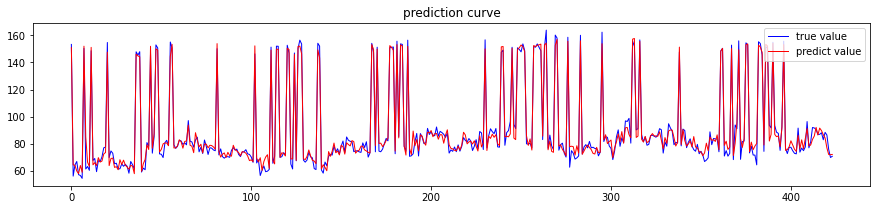

In [20]:
# # 绘制预测值图像和实值图像
# plt.figure(figsize=(15,3))
# plt.plot(np.arange(len(expected)), expected, color='blue', linewidth=1.0, linestyle='-', label='true value')
# plt.plot(np.arange(len(expected)), predicted, color='red', linewidth=1.0, linestyle='-', label='predict value')
# plt.title('prediction curve')
# plt.legend(loc='upper right')
# plt.show()

In [21]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# # 评价预测的准确性  
# print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
# print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
# print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
# print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

MSE:  19.185124148640856
RMSE:  4.380082664589889
MAE:  3.243550679894154
R^2:  0.9780453930575573


In [22]:
# ypred = bst.predict(dtest)
# print("测试集每个样本的得分\n",ypred)
# ypred_leaf = bst.predict(dtest, pred_leaf=True)
# print("测试集每棵树所属的节点数\n",ypred_leaf)
# ypred_contribs = bst.predict(dtest, pred_contribs=True)
# print("特征的重要性\n",ypred_contribs )

测试集每个样本的得分
 [150.85875   64.51603   64.160835  59.938164  58.032097  64.014984
  58.981712 151.95924   85.09405   66.39088   63.327785 151.0988
  64.49171   66.07586   63.98304   69.79786   66.531265  67.258835
  72.479355  73.62024  147.55603   63.93025   69.14268   69.46839
  62.597977  63.141087  60.875988  68.26344   64.74302   67.93649
  64.25886   62.88571   61.24643   64.151825  63.525566  57.98204
 146.08234  144.76497  144.20981   59.71419   65.38693   68.40106
  79.23174   75.80376  151.90129   76.71602   87.34851  149.98134
 149.03899   73.988655  75.90316   79.97949   80.548965  80.658646
  78.60847  144.42151  153.28403   76.93152   77.02296   78.45052
  82.94107   81.54865   76.7802    81.72459   82.12817   93.78183
  78.88377   78.230125  73.457405  88.18528   82.734215  77.75816
  79.6961    73.30545   79.83526   79.728935  77.032036  78.94026
  78.69397   77.66456   76.046    153.85884   74.401     70.22149
  72.366516  73.28013   69.91117   73.73219   71.321495  70.90

In [23]:
# # 解决matplotlib标题中文乱码
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [26]:
# Train_data.head(0)

,,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,RIPPLE_AIR_BAG_PRESSURE,...,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
WAFER_ID,STAGE,,,,,,,,,,,,,,,,,,,,,


In [27]:
# Train_data.columns

Index(['CHAMBER', 'USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER',
       'USAGE_OF_POLISHING_TABLE', 'USAGE_OF_DRESSER_TABLE',
       'PRESSURIZED_CHAMBER_PRESSURE', 'MAIN_OUTER_AIR_BAG_PRESSURE',
       'CENTER_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
       'RIPPLE_AIR_BAG_PRESSURE', 'USAGE_OF_MEMBRANE',
       'USAGE_OF_PRESSURIZED_SHEET', 'SLURRY_FLOW_LINE_A',
       'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C', 'WAFER_ROTATION',
       'STAGE_ROTATION', 'HEAD_ROTATION', 'DRESSING_WATER_STATUS',
       'EDGE_AIR_BAG_PRESSURE', 'AVG_REMOVAL_RATE'],
      dtype='object')

In [28]:
# # 图片中显示特征的名称
# def ceate_feature_map(features):
#     outfile = open('CMP-PHM2016.fmap', 'w')
#     i = 0
#     for feat in features:
#         outfile.write('{0}\t{1}\tq\n'.format(i, feat))
#         i = i + 1
#     outfile.close()
# ceate_feature_map(Train_data.columns)

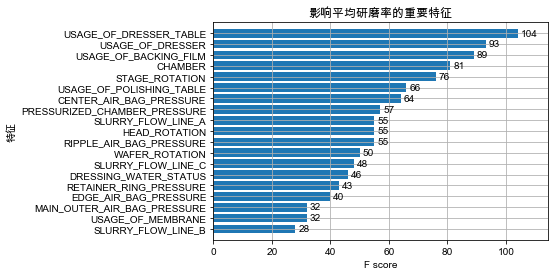

In [32]:
# xgb.plot_importance(bst, height=0.8, title='影响平均研磨率的重要特征', ylabel='特征', fmap='CMP-PHM2016.fmap')
# plt.rc('font', family='Arial Unicode MS', size=5)
# plt.show()

## LightGBM的一种底层写法

In [100]:
# # 一种不太方便的写法
# import lightgbm as lgb

# params = {
#     'objective': 'regression',
#     'metric':'mse',
#     'num_leaves': 50 ,
#     'learning_rate': 0.1,
#     'bagging_fraction': 0.9,
#     'feature_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbosity': 0
# }

# lgb_train = lgb.Dataset(train_x, label=train_y)
# lgb_eval = lgb.Dataset(test_x, label=test_y, reference=lgb_train)

# lgbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=20
#                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 713.598
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 601.504
[3]	valid_0's l2: 493.832
[4]	valid_0's l2: 405.695
[5]	valid_0's l2: 334.589
[6]	valid_0's l2: 288.794
[7]	valid_0's l2: 240.25
[8]	valid_0's l2: 208.995
[9]	valid_0's l2: 177.009
[10]	valid_0's l2: 149.172
[11]	valid_0's l2: 126.958
[12]	valid_0's l2: 109.022
[13]	valid_0's l2: 94.6821
[14]	valid_0's l2: 84.5141
[15]	valid_0's l2: 73.9262
[16]	valid_0's l2: 65.009
[17]	valid_0's l2: 59.7495
[18]	valid_0's l2: 53.6127
[19]	valid_0's l2: 48.0235
[20]	valid_0's l2: 45.1412
[21]	valid_0's l2: 41.3934
[22]	valid_0's l2: 38.3555
[23]	valid_0's l2: 35.7092
[24]	valid_0's l2: 33.6689
[25]	valid_0's l2: 31.7225
[26]	valid_0's l2: 30.7442
[27]	valid_0's l2: 29.5267
[28]	valid_0's l2: 28.4903
[29]	valid_0's l2: 27.6274
[3

In [101]:
# # 预测值
# expected = test_y
# predicted = lgbm.predict(test_x, num_iteration=lgbm.best_iteration)

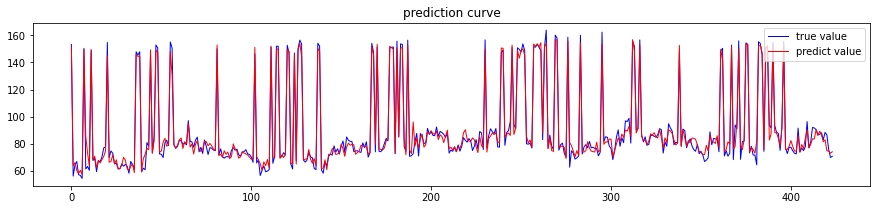

In [102]:
# # 绘制预测值图像和实值图像
# plt.figure(figsize=(15,3))
# plt.plot(np.arange(len(expected)), expected, color='blue', linewidth=1.0, linestyle='-', label='true value')
# plt.plot(np.arange(len(expected)), predicted, color='red', linewidth=1.0, linestyle='-', label='predict value')
# plt.title('prediction curve')
# plt.legend(loc='upper right')
# plt.show()

In [103]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# # 评价预测的准确性  
# print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
# print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
# print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
# print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

MSE:  20.067890329168453
RMSE:  4.479719894052356
MAE:  3.191582071570874
R^2:  0.9770351945117774


## 1.1 预测和绘图函数

In [18]:
def model_fit_predict(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    expected = test_y
    predicted = model.predict(test_x)
    
    return model, expected, predicted

In [17]:
def plot_curve(expected, predicted):
    # 绘制预测值图像和实值图像
    plt.figure(figsize=(15,3))
    plt.plot(np.arange(len(expected)),expected,color='blue',linewidth=1.0,linestyle='-',label='true value')
    plt.plot(np.arange(len(predicted)),predicted,color='red',linewidth=1.0,linestyle='-',label='predict value')
    plt.title('prediction curve')
    plt.legend(loc='upper right') 
    plt.show()
    
    print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
    print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
    print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
    print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

## 1.2 回归预测
整理到同一个文件里边（1）线性模型：Lasso/Ridge/Elastic/BayesianRidge（2）KNN（3）树模型DecisionTree/RandomForest（4）集成模型：AdaBoost/GBDT（GradientBoostingDecisionTree）/Xgboost/LightGBM（5）Stacking

### Lasso

/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2353.2940622531605, tolerance: 178.43321620525015
  model = cd_fast.enet_coordinate_descent(


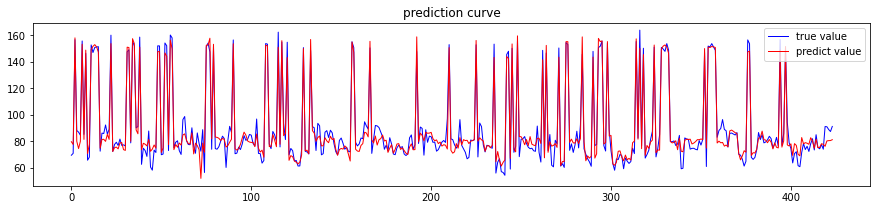

MSE:  38.638590528189575
RMSE:  6.215994733603751
MAE:  4.792436553848259
R^2:  0.9557837071428862


In [38]:
# Lasso模型
model_lasso = Lasso(alpha=0.025)
model_lasso, expected, predicted = model_fit_predict(model_lasso, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### Ridge

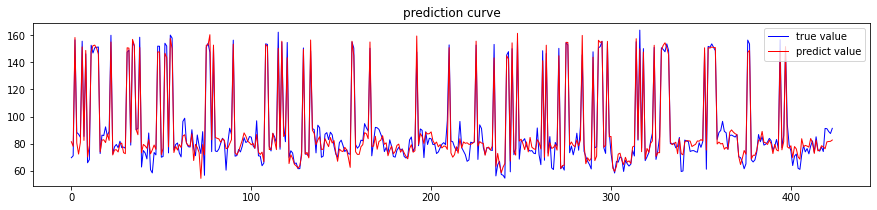

MSE:  37.928659525928815
RMSE:  6.158624808017518
MAE:  4.730763066217139
R^2:  0.9565961207603396


In [37]:
# Ridge
model_ridge = Ridge(alpha=0.002)
model_ridge, expected, predicted = model_fit_predict(model_ridge, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### ElasticNet

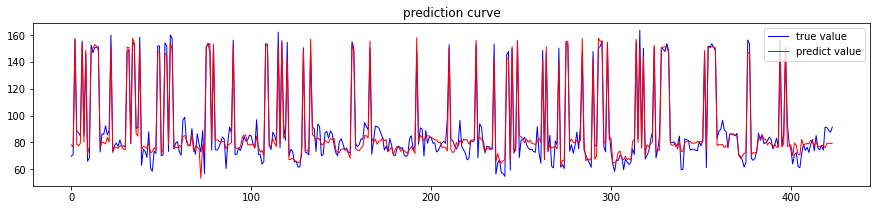

MSE:  42.023965340171806
RMSE:  6.482589400862267
MAE:  5.074097569242621
R^2:  0.9519096340446842


In [36]:
# ElasticNet
model_elastic = ElasticNet(alpha=0.02, l1_ratio=0.7)
model_elastic, expected, predicted = model_fit_predict(model_elastic, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### BayesianRidge

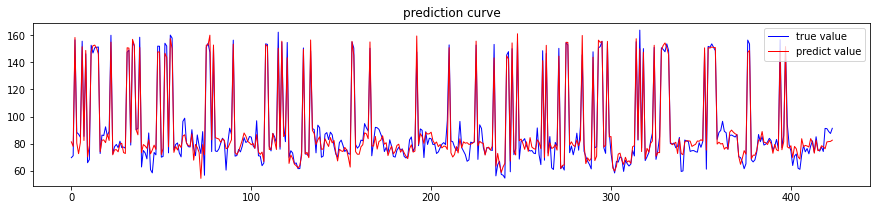

MSE:  37.902531379827856
RMSE:  6.1565031779272115
MAE:  4.732038880491771
R^2:  0.9566260206543062


In [35]:
# BayesianRidge
model_baysian_ridge = BayesianRidge(n_iter=300, alpha_1=1e-9, alpha_2=1e-9, lambda_1=1e-9, lambda_2=1e-9, alpha_init=0.2, compute_score=False)
model_baysian_ridge, expected, predicted = model_fit_predict(model_baysian_ridge, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### KNN

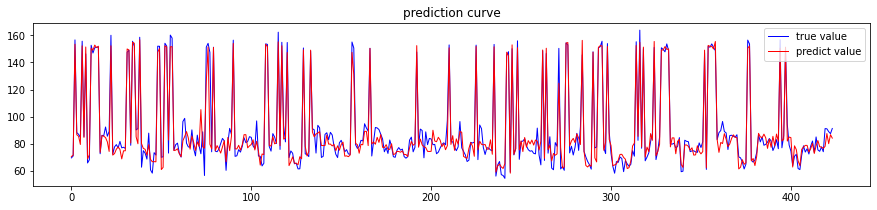

MSE:  50.56151797121117
RMSE:  7.1106622737415375
MAE:  4.789038207547128
R^2:  0.942139636685654


In [34]:
# KNN
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn, expected, predicted = model_fit_predict(model_knn, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### DecisionTree

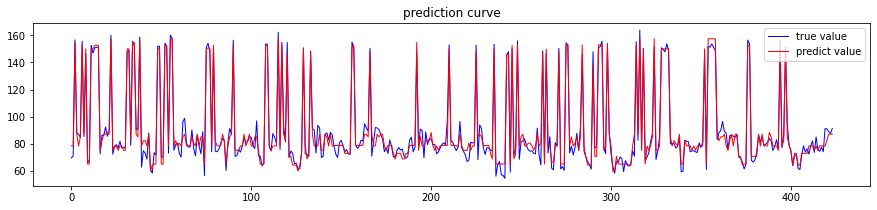

MSE:  24.31934113943926
RMSE:  4.9314644011124384
MAE:  3.7669529575744036
R^2:  0.9721700223736426


In [33]:
# DecisionTree
model_dt = DecisionTreeRegressor(max_depth=5)
model_dt, expected, predicted = model_fit_predict(model_dt, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### RandomForest

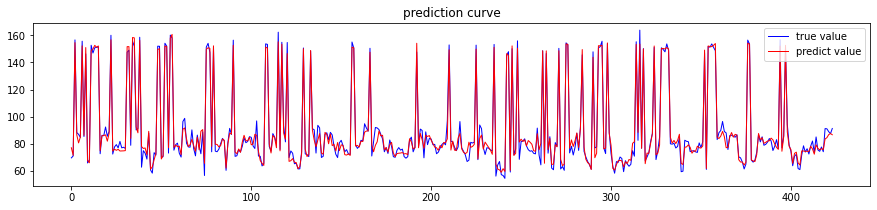

MSE:  16.25273686528675
RMSE:  4.031468326216485
MAE:  2.954550070754675
R^2:  0.9814010872772175


In [32]:
# RandomForest
model_randomForest = RandomForestRegressor(criterion='mse', n_estimators=100, random_state=0)
model_randomForest, expected, predicted = model_fit_predict(model_randomForest, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### AdaBoost

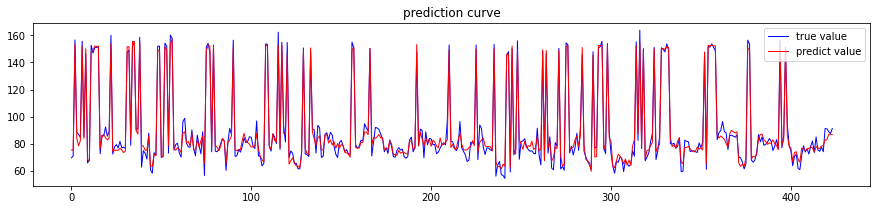

MSE:  19.295471629319838
RMSE:  4.392661110229178
MAE:  3.439440452468694
R^2:  0.9779191162846459


In [31]:
# AdaBoost
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=None)
model_ada, expected, predicted = model_fit_predict(model_ada, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### GBDT

In [34]:
# gbdt
for _ in range(0,10):
    predicteds = []
    model_gbdt = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
    model_gbdt, expected, predicted = model_fit_predict(model_gbdt, train_x, train_y, test_x, test_y)
    
    predicteds.append(predicted)

predicted = np.mean(predicteds, axis=0)
plot_curve(expected, predicted)

ValueError: could not convert string to float: 'B'

### Xgboost

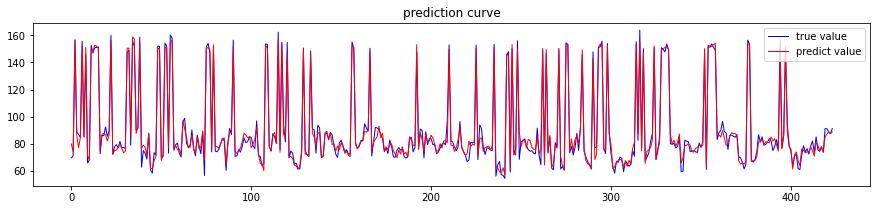

MSE:  15.214575660819152
RMSE:  3.9005865790697625
MAE:  2.9273199041977938
R^2:  0.9825891130106134


In [120]:
# xgboost
for _ in range(0,10):
    predicteds = []
    
    model_xgb = xgb.XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
    model_xgb, expected, predicted = model_fit_predict(model_xgb, train_x, train_y, test_x, test_y)
    
    predicteds.append(predicted)
    
predicted = np.mean(predicteds, axis=0)
plot_curve(expected, predicted)

### LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


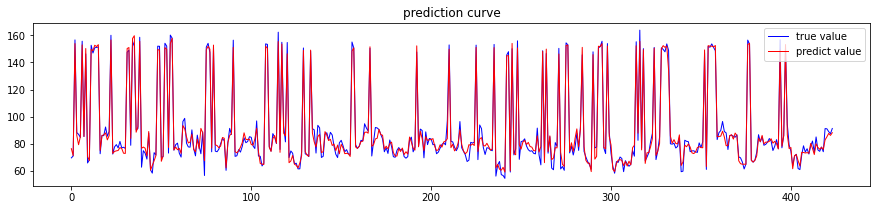

MSE:  15.906544173309356
RMSE:  3.988300913084337
MAE:  3.0080627725227944
R^2:  0.9817972548714339


In [52]:
# lightGBM
model_lgbm = lgbm.LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model_lgbm, expected, predicted = model_fit_predict(model_lgbm, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

### Stacking

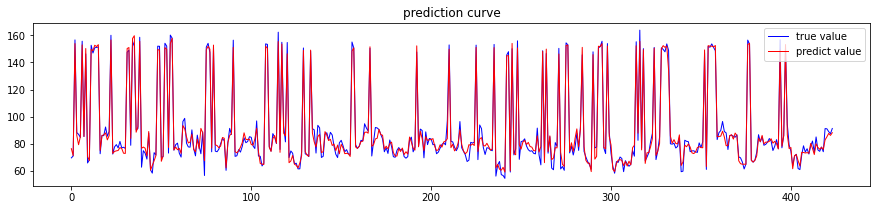

MSE:  15.906544173309356
RMSE:  3.988300913084337
MAE:  3.0080627725227944
R^2:  0.9817972548714339


In [68]:
# stacking 
from sklearn.ensemble import StackingRegressor

clf1 = DecisionTreeRegressor(max_depth=5)
clf2 = KNeighborsRegressor(n_neighbors=3)
clf3 = ElasticNet(alpha=0.02, l1_ratio=0.7)
estimators = [('DT', clf1), ('knn', clf2), ('elastic', clf3)]

model_stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge())
model_stacking = model_fit_predict(model_stacking, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

# 2 半监督回归

## 2.1 划分未标记和已标记数据

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
def set_labeled_ratio(a = 0.2): #默认已标记数据占比为0.2 

    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(train_x, train_y, #这里借用了下train_test_split来划分已标记和未标记数据，和CoReg算法中一样用shuffle也可以
                                                    train_size=a, test_size=1-a, 
                                                    random_state=45)

    return X_labeled,X_unlabeled,y_labeled,y_unlabeled

In [70]:
X_labeled,X_unlabeled,y_labeled,y_unlabeled = set_labeled_ratio(0.3)
y_labeled = y_labeled.reshape(-1,1) 
y_unlabeled = y_unlabeled.reshape(-1,1)

In [71]:
X = np.vstack((X_labeled,X_unlabeled))

## 2.2 Coreg

Starting trial 1:
Finished trial 1: 681.41s elapsed



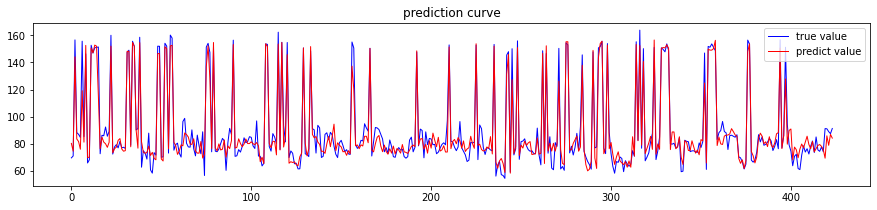

MSE:  58.80403650606953
RMSE:  7.668379001201592
MAE:  5.539016866766245
R^2:  0.9327072632880895


In [116]:
# coreg
from utils.coreg.coreg import Coreg
model_coreg = Coreg(k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=1000, trials=1, verbose=False)
model_coreg, expected, predicted = model_fit_predict(model_coreg, X, y_labeled, test_x, test_y)
plot_curve(expected, predicted)

In [ ]:
# 另一种写法
# import sys
# sys.path.append(r"D:\Projects\PHM DATA CHALLENGE CMP DATA SET\coreg-pipline-master\src")
# import coreg
# #CoReg半监督回归
# model_coreg = coreg.Coreg(k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=1000, trials=1, verbose=False)

## 2.3 Corareg

Starting trial 1:
Finished trial 1: 19.52s elapsed



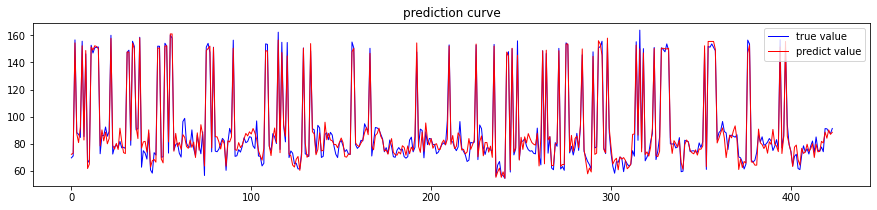

MSE:  29.017968673913973
RMSE:  5.386832898272785
MAE:  4.038031308962172
R^2:  0.9667931209843629


In [115]:
import utils.corareg.corareg as corareg
model_corareg = corareg.Coreg(k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=100, trials=1, verbose=False)
model_corareg, expected, predicted = model_fit_predict(model_corareg, X, y_labeled, test_x, test_y)
plot_curve(expected, predicted)

In [125]:
# 另一种写法
# import sys
# sys.path.append(r"D:\Projects\PHM DATA CHALLENGE CMP DATA SET\corareg-pipline-master\src")
# import corareg
# #CoRAReg半监督回归
# CoRAReg = corareg.Coreg(k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=100, trials=1, verbose=False)

## Cross Validation

In [125]:
## 
from sklearn.model_selection import cross_validate, cross_val_predict
# model_lasso = Lasso(alpha=0.025)
# cross_validate()


In [149]:
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50, random_state=None)
scores = cross_validate(model_ada, train_x, train_y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)

In [150]:
scores

{'fit_time': array([0.36230683, 0.358248  , 0.36126184, 0.36394906, 0.36363697]),
 'score_time': array([0.00490212, 0.00473428, 0.00503016, 0.00533795, 0.00555086]),
 'test_score': array([-23.65851255, -23.03828971, -39.21420354, -22.41650421,
        -31.92512796])}

# Pipeline

/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2353.2940622531605, tolerance: 178.43321620525015
  model = cd_fast.enet_coordinate_descent(


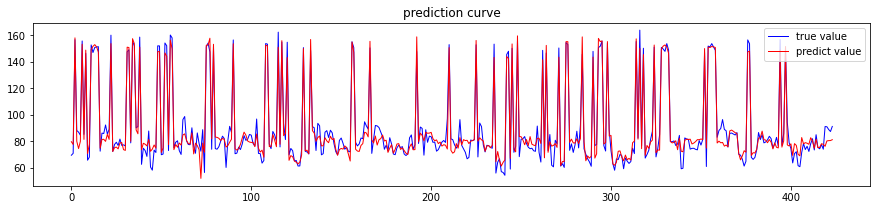

MSE:  38.638590528189575
RMSE:  6.215994733603751
MAE:  4.792436553848259
R^2:  0.9557837071428862


In [22]:
pipe_vm = Pipeline([('ss', StandardScaler()), ('lasso', Lasso(alpha=0.025))])
pipe_vm.fit(train_x, train_y)
expected = test_y
predicted = pipe_vm.predict(test_x)
plot_curve(expected, predicted)